In [1]:
NUMPY_EXPERIMENTAL_ARRAY_FUNCTION = 1  # FIXME is this needed?

In [2]:
import numpy as np
import cupy
import cupy as cp
import matplotlib.pyplot as plt
from string import Template
from math import sin, cos, atan2, sqrt

In [3]:
import numba
from numba import jit, njit, prange

In [4]:
print(cupy.cuda.Device())

<CUDA Device 0>


### Data residency

In [5]:
x_cpu = np.linspace(0, 1, 1000)
x_gpu = cupy.asarray(x_cpu)
# x_gpu = cp.linspace(0, 1, 1000)

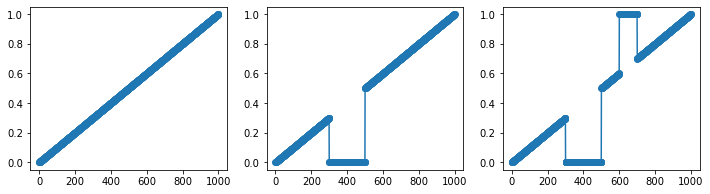

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# axs[0].plot(x_gpu, marker='o')  # error, mpl cannot work on gpu data
axs[0].plot(x_gpu.get(), marker='o')

# mask gpu array using gpu data
x_gpu[(x_gpu>0.3) & (x_gpu<0.5)] = 0
axs[1].plot(x_gpu.get(), marker='o')

# mask gpu array using cpu data
x_gpu[(x_cpu>0.6) & (x_cpu<0.7)] = 1
axs[2].plot(x_gpu.get(), marker='o')

In [7]:
x_test = np.empty_like(x_gpu)
type(x_test)

cupy.core.core.ndarray

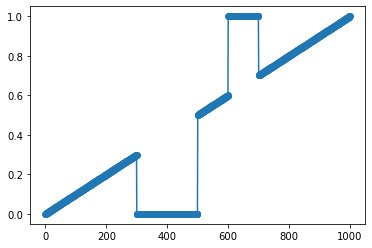

In [8]:
x_test = np.empty(x_gpu.shape)
x_gpu.get(out=x_test)
plt.plot(x_test, marker='o')

### Basic calculations

In [37]:
x_cpu = np.linspace(0, 1, int(1e6))
x_gpu = cupy.asarray(x_cpu)

In [36]:
@jit
def sin_numba(x):
    return np.sin(x)

#### cos

In [28]:
%timeit np.sin(x_cpu)

10.6 ms ± 15.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
%timeit sin_numba(x_cpu)

10.5 ms ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%timeit cupy.sin(x_gpu)

23 µs ± 24.6 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [30]:
%timeit np.sin(x_gpu)

23 µs ± 7.04 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### sum

In [31]:
%timeit np.sum(x_cpu)

338 µs ± 174 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
%timeit cupy.sum(x_gpu)

710 µs ± 29.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [33]:
%timeit np.sum(x_gpu)

710 µs ± 129 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Shuffling a 2d array along the first dimension

In [19]:
x_cpu = np.random.random((int(1e6), 6))
x_gpu = cupy.asarray(x_cpu)

In [20]:
@jit
def shuffle_numba(x):
    return np.random.shuffle(x)

In [21]:
%timeit np.random.shuffle(x_cpu)

906 ms ± 8.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%timeit shuffle_numba(x_cpu)

158 ms ± 5.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit cupy.random.shuffle(x_gpu)

445 µs ± 19 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
# %timeit np.random.shuffle(x_gpu)  # FIXME freezes

### 1d histogram

In [34]:
x_cpu = np.random.random((int(1e8)),)
x_gpu = cupy.asarray(x_cpu)

In [35]:
@jit
def histogram_numba(x, bins):
    return np.histogram(x, bins)

In [8]:
%timeit np.histogram(x_cpu, 50)

1.11 s ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit histogram_numba(x_cpu, 50)

246 ms ± 391 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit cupy.histogram(x_gpu, 50)

207 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit np.histogram(x_gpu, 50)

206 ms ± 34.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Element-wise operations
- In this example, our cpu "kernel" is written in pure NumPy and all sub-function arguments are numpy.ndaray of shape (3, number_of_vectors).
- This way, we do not need to modify the kernel at all according to the [cupy documentation on interpolerability](https://docs.cupy.dev/en/stable/reference/interoperability.html#numpy):

> <div>cupy.ndarray implements __array_ufunc__ interface (see NEP 13 — A Mechanism for Overriding Ufuncs for details). This enables NumPy ufuncs to be directly operated on CuPy arrays. __array_ufunc__ feature requires NumPy 1.13 or later.</div>

In [2]:
# "vectors" below are 2d numpy arrays of shape (3, number_of_vectors)


def mag(v):
    return np.linalg.norm(v, axis=0)


def unit(v):
    return v / np.linalg.norm(v, axis=0)


# # the following code seems 10% faster for cpu, but similar for gpu
# def pwr(v):
#     return v[0, :]**2 + v[1, :]**2 + v[2, :]**2


# def mag(v):
#     return np.sqrt(pwr(v))


# def unit(v):
#     return v / mag(v)


def inner(v1, v2):
    #     return v1[0, :]*v2[0, :] + v1[1, :]*v2[1, :] + v1[2, :]*v2[2, :]
    return np.sum(v1 * v2, axis=0)


def cross(v1, v2):
    return np.cross(v1, v2, axisa=0, axisb=0, axisc=0)


# the "kernel"
def kernel(x1, x2, v1, v2):
    dv = v1 - v2
    v_avg = 0.5 * (v1 + v2)
    dv_perp = cross(v_avg, cross(dv, v_avg))

    l_unit = unit(v_avg)
    m_unit = unit(dv_perp)
    n_unit = cross(l_unit, m_unit)

    dx = x1 - x2
    l = inner(l_unit, dx)
    m = inner(m_unit, dx)
    n = inner(n_unit, dx)

    result = (mag(dv))**2
    
    return l, m, n, result

In [3]:
Nsamples = int(1e6)
xyz1 = np.random.random((3, Nsamples))
xyz2 = np.random.random((3, Nsamples))
vxyz1 = np.random.random((3, Nsamples))
vxyz2 = np.random.random((3, Nsamples))

In [8]:
%timeit l, m, n, z = kernel(xyz1, xyz2, vxyz1, vxyz2)

125 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
xyz1_gpu = cupy.asarray(xyz1)
xyz2_gpu = cupy.asarray(xyz2)
vxyz1_gpu = cupy.asarray(vxyz1)
vxyz2_gpu = cupy.asarray(vxyz2)

In [10]:
%timeit l, m, n, z = kernel(xyz1_gpu, xyz2_gpu, vxyz1_gpu, vxyz2_gpu)

1.82 ms ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
